In [9]:
import logging
import warnings
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid
from matplotlib.gridspec import GridSpec

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [10]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

from matplotlib.colors import ListedColormap

In [11]:
path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/result_data/'
fig_path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/figures/'
years = [2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040]
first_year = 2024
last_year = 2040
discountrate = 0.04

In [12]:
# Helper functions

def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    # for carrier in carriers:
    #     production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6
 
    production_data["CCGT"] = get_snapshot_generation(year, first_date, second_date, "CCGT").sum() /1e6
    production_data["OCGT"] = get_snapshot_generation(year, first_date, second_date, "OCGT").sum() /1e6
    production_data["oil"] = get_snapshot_generation(year, first_date, second_date, "oil").sum() /1e6
    production_data["geothermal"] = get_snapshot_generation(year, first_date, second_date, "geothermal").sum() /1e6
    production_data["hydro"] = get_snapshot_generation(year, first_date, second_date, "hydro").sum() /1e6
    production_data["onwind"] = get_snapshot_generation(year, first_date, second_date, "onwind").sum() /1e6
    production_data["solar"] = get_snapshot_generation(year, first_date, second_date, "solar").sum() /1e6
    production_data["biomass"] = get_snapshot_generation(year, first_date, second_date, "biomass").sum() /1e6
    production_data["ror"] = get_snapshot_generation(year, first_date, second_date, "ror").sum() /1e6
    production_data["load"] = get_snapshot_generation(year, first_date, second_date, "load").sum() /1e6
 
    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1e6)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex().sum() + network.statistics.opex().sum())/1e6

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom_opt'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom_opt'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_hydro(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom_opt'].sum()

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_charge(year):
    network = networks[year]
    capacities_discharge = network.links.groupby(by='carrier')['p_nom'].sum()
    capacities_discharge_df = capacities_discharge.to_frame().transpose()
    capacities_discharge_df.index = [year]
    return capacities_discharge_df

def get_installed_capacity_battery(year):
    network = networks[year]
    storage_capacity = network.stores.groupby(by='carrier')['e_nom'].sum()
    storage_capacity_df = storage_capacity.to_frame().transpose()
    storage_capacity_df.index = [year]
    return storage_capacity_df

def get_installed_capacity_lines(year):
    network = networks[year]
    lines_capacity = network.lines.groupby(by='carrier')['s_nom'].sum()
    lines_capacity_df = lines_capacity.to_frame().transpose()
    lines_capacity_df.index = [year]
    return lines_capacity_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def get_new_installed_hydro(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)

    return grouped_cap_change_B

def get_new_installed_battery(years):
    capacity = {'Charger':[], 'Discharger':[],'Battery Storage':[], 'year':[]}

    for y in years:
        net=networks[y]

        capacity["year"].append(y)

        charger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery charger', 0)
        charger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery charger', 0)
        capacity['Charger'].append(charger_next_capacity-charger_capacity)

        discharger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery discharger', 0)
        discharger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery discharger', 0)
        capacity['Discharger'].append(discharger_next_capacity-discharger_capacity)

        battery_storage_capacity = net.stores.groupby('carrier').e_nom.sum().get('battery', 0)
        battery_storage_next_capacity = net.stores.groupby('carrier').e_nom_opt.sum().get('battery', 0)
        capacity['Battery Storage'].append(battery_storage_next_capacity-battery_storage_capacity)

    capacity_battery_df = pd.DataFrame(capacity)
    capacity_battery_df.set_index("year", inplace=True)

    return capacity_battery_df

def get_new_installed_lines(years):
    data_agg = pd.DataFrame({})

    for y in years:
        net = networks[y]
        lines = pd.DataFrame(net.lines)

        lines["line_id"] = lines.index
        
        lines["zubau"] = lines["s_nom_opt"] - lines["s_nom"]
        lines["year"] = np.ones(len(lines["s_nom_opt"]), dtype=int) * y

        data_agg = pd.concat([data_agg, lines[["year", "line_id", "zubau"]]])

    grouped_cap_change_L = data_agg.groupby(['year', 'line_id']).sum().unstack()

    grouped_cap_change_L.columns = grouped_cap_change_L.columns.droplevel(0)
    grouped_cap_change_L = grouped_cap_change_L.clip(lower=0)
    grouped_cap_change_L = grouped_cap_change_L.sort_index(axis=1)

    return grouped_cap_change_L

# def get_new_installed_lines(years):


#     capacity = {'year':[], 'Line':[]}

#     for y in years:
#         net = networks[y]
#         yearly_capacity_change = 0
#         capacity['year'].append(y)
        
#         for line in net.lines.index:
#             yearly_capacity_change = net.lines.loc[line].s_nom_opt - net.lines.loc[line].s_nom
#             capacity['Line'].append(yearly_capacity_change)

#     capacity_lines_df = pd.DataFrame(capacity)
#     capacity_lines_df.set_index("year", inplace=True)
      
#     return capacity_lines_df

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal', 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown, brown2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_marginal_cost(y, carrier):
    network = networks[y]
    carrier_data = network.generators.loc[network.generators['carrier'] == carrier]
    if not carrier_data.empty:
        marginal_cost = carrier_data['marginal_cost'].iloc[0]
        return marginal_cost
    else:
        return 0 
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))

def calculate_present_value(future_value, year, base_year, discount_rate=discountrate):
    return future_value / ((1 + discount_rate) ** (year - base_year))


def capital_recovery_factor(lifetime, discount_rate):
    return discount_rate / (1 - (1 + discount_rate) ** -lifetime)

def annual_capex(years):

    new_installed_cap = get_new_installed(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    cap_capex = 0
    bat_capex = 0
    line_capex = 0
    for y in years:
        installed_cap = get_installed_capacity(y)
        installed_bat = get_installed_capacity_battery(y)
        installed_charge = get_installed_capacity_charge(y)
        network = networks[y]
        

        for carrier in new_installed_cap.columns:
            if carrier != 'hydro':
                cap_capex += new_installed_cap.loc[y, carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
        for carrier in installed_cap.columns:
            if carrier == 'hydro':
                cap_capex += installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == 'ror', 'capital_cost'].iloc[0]
            else:
                cap_capex += installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]

        bat_capex += installed_bat.loc[y, 'battery'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        bat_capex += installed_charge.loc[y, 'battery charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        bat_capex += new_installed_bat.loc[y, 'Charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        
        
        if y != final_year:
            line_capex += new_installed_lines.loc[y, 'Line'] *network.lines.loc[network.lines['carrier'] == 'AC', 'capital_cost'].iloc[0]

        capex_dict = {
            'Generator' : cap_capex,
            'Battery' : bat_capex,
            'Line' : line_capex
        }
    return capex_dict #EUR

def capacity_factors(year):
    carrier_mapping = {
        'Biomass': 'biomass',
        'Combined-Cycle Gas': 'CCGT',
        'Oil': 'oil',
        'Onshore Wind': 'onwind',
        'Open-Cycle Gas': 'OCGT',
        'Solar': 'solar',
        'Run of River': 'hydro',
        'Reservoir & Dam': 'hydro_store',
        'Geothermal': 'geothermal'
    }

    network = networks[year]
    network_stats = network.statistics()
    cp = {output: [] for output in carrier_mapping.values()}

    for carrier_stat, carrier in carrier_mapping.items():
        if carrier_stat == 'Reservoir & Dam':
            value = network_stats.loc['StorageUnit']['Capacity Factor'][carrier_stat]
            cp[carrier] = value
        else:
            value = network_stats.loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
            cp[carrier] = value

    return cp

def hourly_capacity_factors(year,carrier):
    network = networks[year]
    gen_indices = network.generators.query(f"carrier == '{carrier}'").index
    capacity_factors = pd.DataFrame(index=gen_indices, columns=range(168))
    
    # Loop over each generator index to calculate capacity factors
    for gen_index in gen_indices:
        if gen_index in network.generators_t.p:
            # Assuming each entry in the dictionary is a DataFrame or Series with dispatch values
            gens_dispatch = network.generators_t.p[gen_index].iloc[:168]
            gens_capacity = network.generators.loc[gen_index, 'p_nom_opt']
            
            # Calculate capacity factor
            capacity_factor = gens_dispatch / gens_capacity
            
            # Store the capacity factors in the DataFrame
            capacity_factors.loc[gen_index] = capacity_factor.values
    return capacity_factors

def calculate_annuity(n, r):
    if n == 0:
        return 1
    return r / (1 - ((1 + r) ** -n))

def empire_factor(period,lifetime):
    return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)


def capcost_lines(y):
    capital_cost_df = pd.DataFrame()
    costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
    costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
    costs_pivot['FOM'].fillna(0, inplace=True)
    for line in networks[y].lines.index:
        lifetime = costs_pivot.at['HVAC overhead', 'lifetime']
        FOM = costs_pivot.at['HVAC overhead', 'FOM']
        investment = costs_pivot.at['HVAC overhead', 'investment']

        annuity_factor = calculate_annuity(lifetime, WACC)
        annual_cost = (annuity_factor * investment * networks[y].lines.loc[line,'length']) + FOM

        new_row = pd.DataFrame({'capital_cost': annual_cost}, index=[line])
        capital_cost_df = pd.concat([capital_cost_df, new_row])
    return capital_cost_df


def get_marginal_costs_2():
    costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
    costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
    marginal_cost_df = pd.DataFrame()
    costs_pivot['fuel'].fillna(0, inplace=True)
    costs_pivot['VOM'].fillna(0, inplace=True)
    costs_pivot['efficiency'].fillna(1, inplace=True)
    old_techs = ['OCGT', 'CCGT', 'biomass', 'oil', 'onwind', 'solar', 'ror', 'hydro', 'geothermal', 'battery storage', 'battery inverter', 'HVAC overhead']
    for tech in old_techs:
        if tech in costs_pivot.index:
            efficiency = costs_pivot.at[tech, 'efficiency']
            VOM = costs_pivot.at[tech, 'VOM']
            if tech == 'OCGT' or tech == 'CCGT' or tech == 'oil':
                fuel = costs_pivot.at['gas', 'fuel']
            else:
                fuel = costs_pivot.at[tech, 'fuel']
            marginal_cost = VOM + (fuel / efficiency)

            new_row = pd.DataFrame({'marginal_cost': [marginal_cost ]}, index=[tech])
            marginal_cost_df = pd.concat([marginal_cost_df, new_row])
    return marginal_cost_df

def get_operational_costs(years):
    operational_costs_by_year = []

    for year in years:
        power_prod_df = get_power

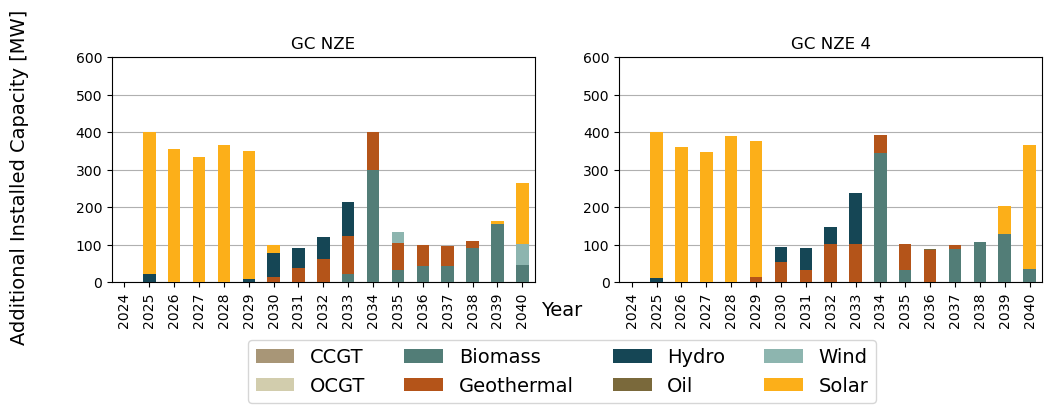

In [13]:
#base_cap_new_battery_capacity = pd.read_csv(path + 'base_cap_new_battery_capacity.csv', index_col=0)
#base_cap_4_new_battery_capacity = pd.read_csv(path + 'base_cap_4_new_battery_capacity.csv', index_col=0)
gradual_NZE_new_capacity = pd.read_csv(path + 'gradual_NZE_new_capacity.csv', index_col=0)
gradual_NZE_4_new_capacity = pd.read_csv(path + 'gradual_NZE_4_new_capacity.csv', index_col=0)


fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

axes = axes.flatten()

new_capacity_scenarios = [
#    ('Base NZE', base_cap_new_battery_capacity),
#    ('BASE NZE 4', base_cap_4_new_battery_capacity),
    ('GC NZE', gradual_NZE_new_capacity),
    ('GC NZE 4', gradual_NZE_4_new_capacity)
]

for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
    capacity_data.plot.bar(stacked=True, ax=ax, color=get_colors(capacity_data.columns), legend=False, zorder=3)
    ax.set_xlabel('')
    ax.set_xticks(range(len(capacity_data.index)))
    ax.set_xticklabels(capacity_data.index, rotation=90)
    ax.set_title(title)
    ax.set_ylim(0, 600)
    ax.grid(axis='y', zorder=0)

# Set the x-axis label on the last subplot
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Additional Installed Capacity [MW]', va='center', rotation='vertical', fontsize=14)

# Create a single shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4, fontsize=14)

# Adjust the layout
plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.15)
plt.savefig(fig_path + 'new_capacity_4.png', dpi=300, bbox_inches='tight')
plt.show()


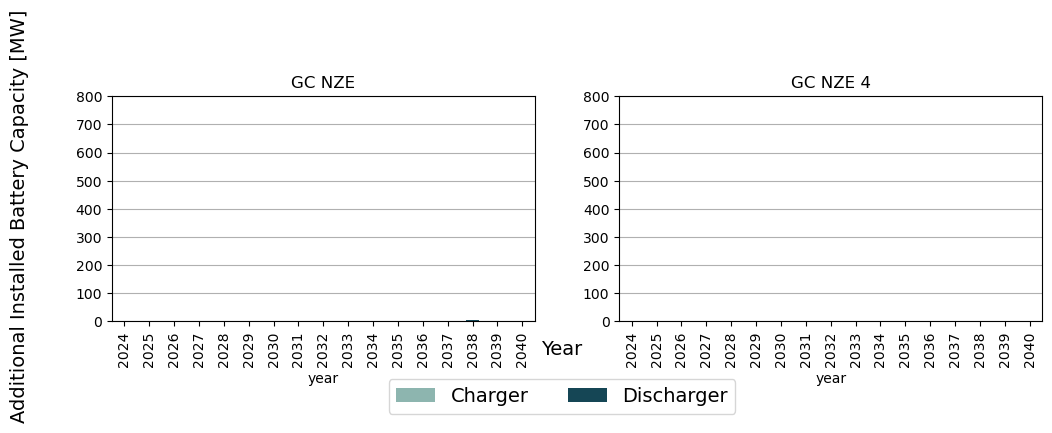

In [14]:
gradual_NZE_new_battery_capacity = pd.read_csv(path + 'gradual_NZE_new_battery_capacity.csv', index_col=0)
gradual_NZE_4_new_battery_capacity = pd.read_csv(path + 'gradual_NZE_4_new_battery_capacity.csv', index_col=0)


fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

axes = axes.flatten()

new_capacity_scenarios = [
#    ('Base NZE', base_cap_new_battery_capacity),
#    ('BASE NZE 4', base_cap_4_new_battery_capacity),
    ('GC NZE', gradual_NZE_new_battery_capacity),
    ('GC NZE 4', gradual_NZE_4_new_battery_capacity)
]

for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
    capacity_data.drop('Battery Storage', axis=1, inplace=True)
    capacity_data.plot.bar(stacked=True, ax=ax, color=[teal4, teal2, teal3], legend=False, zorder=3)
    ax.set_xticks(range(len(capacity_data.index)))
    ax.set_xticklabels(capacity_data.index, rotation=90)
    ax.set_title(title)
    ax.set_ylim(0, 800)
    ax.grid(axis='y', zorder=0)

fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Additional Installed Battery Capacity [MW]', va='center', rotation='vertical', fontsize=14)

# Create a single shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4, fontsize=14)

# Adjust the layout
plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.15)
plt.savefig(fig_path + 'new_battery_capacity_4.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# gradual_NZE_new_battery_capacity = pd.read_csv(path + 'gradual_NZE_new_battery_capacity.csv', index_col=0)
# gradual_NZE_old_new_battery_capacity = pd.read_csv(path + 'gradual_NZE_old_new_battery_capacity.csv', index_col=0)


# fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

# axes = axes.flatten()

# new_capacity_scenarios = [
# #    ('Base NZE', base_cap_new_battery_capacity),
# #    ('BASE NZE 4', base_cap_4_new_battery_capacity),
#     ('GC NZE', gradual_NZE_new_battery_capacity),
#     ('GC NZE old', gradual_NZE_old_new_battery_capacity)
# ]

# for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
#     capacity_data.drop('Battery Storage', axis=1, inplace=True)
#     capacity_data.plot.bar(stacked=True, ax=ax, color=[teal4, teal2, teal3], legend=False, zorder=3)
#     ax.set_xticks(range(len(capacity_data.index)))
#     ax.set_xticklabels(capacity_data.index, rotation=90)
#     ax.set_title(title)
#     ax.set_ylim(0, 1200)
#     ax.grid(axis='y', zorder=0)

# fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
# fig.text(0.04, 0.5, 'Additional Installed Battery Capacity [MW]', va='center', rotation='vertical', fontsize=14)

# # Create a single shared legend
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4, fontsize=14)

# # Adjust the layout
# plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.15)
# plt.savefig(fig_path + 'new_battery_capacity_old.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# gradual_NZE_new_capacity = pd.read_csv(path + 'gradual_NZE_new_capacity.csv', index_col=0)
# gradual_NZE_old_new_capacity = pd.read_csv(path + 'gradual_NZE_old_new_capacity.csv', index_col=0)


# fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

# axes = axes.flatten()

# new_capacity_scenarios = [
# #    ('Base NZE', base_cap_new_battery_capacity),
# #    ('BASE NZE 4', base_cap_4_new_battery_capacity),
#     ('GC NZE', gradual_NZE_new_capacity),
#     ('GC NZE old', gradual_NZE_old_new_capacity)
# ]

# for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
#     capacity_data.plot.bar(stacked=True, ax=ax, color=get_colors(capacity_data.columns), legend=False, zorder=3)
#     ax.set_xlabel('')
#     ax.set_xticks(range(len(capacity_data.index)))
#     ax.set_xticklabels(capacity_data.index, rotation=90)
#     ax.set_title(title)
#     ax.set_ylim(0, 600)
#     ax.grid(axis='y', zorder=0)

# # Set the x-axis label on the last subplot
# fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
# fig.text(0.04, 0.5, 'Additional Installed Capacity [MW]', va='center', rotation='vertical', fontsize=14)

# # Create a single shared legend
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4, fontsize=14)

# # Adjust the layout
# plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.15)
# plt.savefig(fig_path + 'new_capacity_old.png', dpi=300, bbox_inches='tight')
# plt.show()


In [17]:
# #production_base_cap = pd.read_csv(path + 'base_cap_production.csv', index_col=0)
# #production_base_cap_4 = pd.read_csv(path + 'base_cap_4_production.csv', index_col=0)
# production_gradual_cap = pd.read_csv(path + 'gradual_cap_production.csv', index_col=0)
# production_gradual_cap_4 = pd.read_csv(path + 'gradual_cap_4_production.csv', index_col=0)

# fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)  # Adjust figsize as needed

# # Flatten the 2D array of axes to 1D for easier iteration
# axes = axes.flatten()

# # Define your scenarios
# scenarios = [
#     #(production_base_cap, 'BASE NZE'),
#     #(production_base_cap_4, 'BASE NZE 4'),
#     (production_gradual_cap, 'GC NZE'),
#     (production_gradual_cap_4, 'GC NZE 4')
# ]

# # Loop through the scenarios to create each subplot
# for ax, (production_data, title) in zip(axes, scenarios):
#     # Ensure production_data is a DataFrame and not a numpy array
#     if isinstance(production_data, pd.DataFrame):
#         ax.stackplot(production_data.index, production_data.T, 
#                      colors=get_colors(production_data.columns), labels=production_data.columns)
#         ax.set_ylim(0, 20)
#         ax.set_xlim(2023, 2037)
#         ax.set_title(title)
#     else:
#         print(f"Data for {title} is not in DataFrame format.")

# # Set the shared x and y-axis labels
# fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
# fig.text(0.04, 0.5, 'Power Generation [TWh]', va='center', rotation='vertical', fontsize=14)

# colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4, grey1]
# labels = [label for label in production_base_cap.columns if label != 'Nbattery']  # Exclude 'Nbattery'
# patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors) if label != 'Nbattery']
# handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
# fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')

# plt.subplots_adjust(hspace=0.3, bottom=0.1)

# # Save the figure
# plt.savefig(fig_path + 'power_prod_4.png', dpi=300, bbox_inches='tight') 
# plt.show()

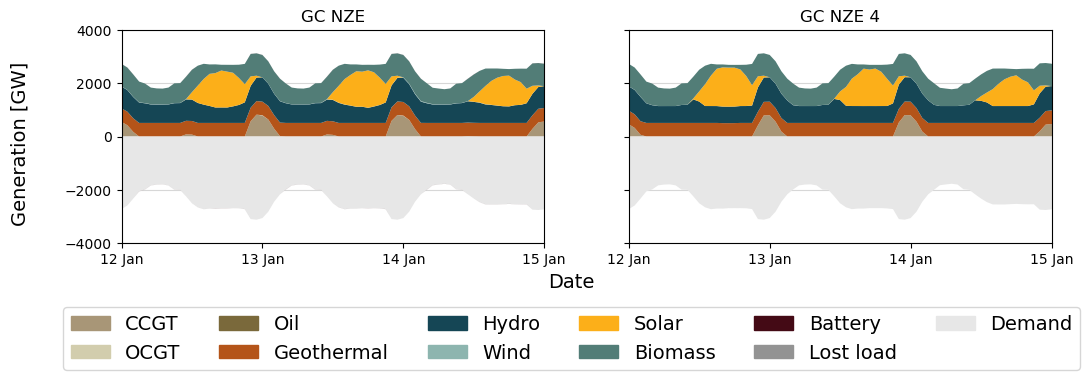

In [18]:
#snapshot_base_cap = pd.read_csv(path + 'base_cap_snapshots.csv', index_col=0, parse_dates=True)
#snapshot_base_cap_4 = pd.read_csv(path + 'base_cap_4_snapshots.csv', index_col=0, parse_dates=True)
snapshot_gradual_cap = pd.read_csv(path + 'gradual_NZE_snapshots.csv', index_col=0, parse_dates=True)
snapshot_gradual_cap_4 = pd.read_csv(path + 'gradual_NZE_4_snapshots.csv', index_col=0, parse_dates=True)

first_date = "2013-01-12"
second_date = "2013-01-15"
start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

# Create the subplots with 2 columns and 3 rows
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define your scenarios
scenarios = [
    #('Base NZE', snapshot_base_cap),  
    #('Base NZE 4', snapshot_base_cap_4),
    ('GC NZE', snapshot_gradual_cap),
    ('GC NZE 4', snapshot_gradual_cap_4)
]

# Loop through the scenarios to create each subplot
for ax, (title, data) in zip(axes, scenarios):
    # Plot the data using stackplot or any other plotting function
    ax.stackplot(data.index, data['CCGT'], data['OCGT'], data['Oil'], data['Geothermal'], data['Hydro'],
                 data['Wind'], data['Solar'], data['Biomass'], data['Battery'], data['Lost load'],
                 colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4], zorder=2)
    ax.stackplot(data.index, data['Demand'], data['Nbattery'], colors=[grey1, brown], zorder=2)
    ax.set_title(title)
    ax.set_xlim(start_date, end_date)
    ax.grid(axis='y', color=grey2)
    ax.set_ylim(-4000,4000)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Generation [GW]', va='center', rotation='vertical', ha='center', fontsize=14)
colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4, grey1]
labels = [label for label in snapshot_gradual_cap.columns if label != 'Nbattery']  # Exclude 'Nbattery'
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors) if label != 'Nbattery']
# Create and place the legend
handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=14)

plt.subplots_adjust(hspace=0.2, bottom=0.17)

# Save the figure
plt.savefig(fig_path + 'snapshots_4.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# snapshot_base = pd.read_csv(path + 'base_snapshots.csv', index_col=0, parse_dates=True)
# snapshot_sudden = pd.read_csv(path + 'sudden_snapshots.csv', index_col=0, parse_dates=True)
# snapshot_gradual = pd.read_csv(path + 'gradual_snapshots.csv', index_col=0, parse_dates=True)


# first_date = "2013-01-09"
# second_date = "2013-01-15"
# year = 2037

# first_date_num = mdates.date2num(pd.to_datetime(first_date))
# second_date_num = mdates.date2num(pd.to_datetime(second_date))

# start_date = pd.to_datetime(first_date)
# end_date = pd.to_datetime(second_date)


# fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# # Assuming the snapshots dataframes are prepared correctly
# scenarios = [
#     (snapshot_base, 'Base'),
#     (snapshot_sudden, 'Sudden'),
#     (snapshot_gradual, 'Gradual')
# ]

# # Define colors for each generation type
# color_dict = get_colors(snapshot_base.columns)

# # Loop through the scenarios to create each subplot
# for ax, (data, title) in zip(axes, scenarios):
#     # Positive and negative parts of the battery
#     nbattery = data['Battery'].clip(upper=0)
#     pbattery = data['Battery'].clip(lower=0)
    
#     # Your stackplot call here, adjust as needed
# for ax, (data, title) in zip(axes, scenarios):
#     ax.stackplot(data.index, data['CCGT'], data['OCGT'], data['Oil'], data['Geothermal'], data['Hydro'],
#                  data['Wind'], data['Solar'], data['Biomass'], data['Battery'], data['Lost load'],
#                  colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4], zorder=2)
#     ax.stackplot(data.index, data['Demand'], data['Nbattery'], colors=[grey1, brown], zorder=2)
#     ax.set_title(title)
#     ax.set_ylim(-3500, 3500)  # Set the limits of y-axis, adjust as necessary

# first_date_matplotlib = mdates.date2num(pd.to_datetime(first_date))
# second_date_matplotlib = mdates.date2num(pd.to_datetime(second_date))

# # Set the x-axis limits using Matplotlib's internal date format
# axes[-1].set_xlim(pd.to_datetime(first_date), pd.to_datetime(second_date))

# # Format the x-axis to display dates in a human-readable format
# axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

# axes[-1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # Adjust 'nbins' as needed for your data

# axes[-1].set_xlabel('Date')




# fig.text(0.04, 0.5, 'Generation [GW]', va='center', rotation='vertical')
# colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4, grey1]
# labels = [label for label in snapshot_base.columns if label != 'Nbattery']  # Exclude 'Nbattery'
# patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors) if label != 'Nbattery']
# fig.legend(handles=patches, loc='center left', bbox_to_anchor=(0.92, 0.5), title='Carrier')

# # Adjust layout
# plt.subplots_adjust(hspace=0.3, bottom=0.15)

# # Save the figure
# plt.savefig(fig_path + 'snapshots.png', dpi=300, bbox_inches='tight')
# plt.show()

In [20]:
# gradual_nze_capex = pd.read_csv(path + 'gradual_NZE_capex_by_type.csv', index_col=0)
# gradual_nze_4_capex = pd.read_csv(path + 'gradual_NZE_4_capex_by_type.csv', index_col=0)

# gradual_nze_capex_total = gradual_nze_capex.sum(axis=1)
# gradual_nze_4_capex_total = gradual_nze_4_capex.sum(axis=1)

# desired_order = ['AC', 'Battery Storage', 'Biomass', 'Combined_Cycle', 'Geothermal', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Reservoir & Dam', 'Run of River', 'Solar', 'battery charger', 'battery discharger', 'load']

# all_data = pd.concat([gradual_nze_capex_total, gradual_nze_4_capex_total], axis=0)
# all_data.index = ['GC NZE', 'GC NZE 4']
# all_data = all_data[desired_order]

# ax = all_data.plot(kind='bar', stacked=True, figsize=(10, 4), color=get_colors(all_data.columns), legend=False, zorder=3, fontsize=14)   
# plt.setp(ax.get_xticklabels(), rotation=0)
# ax.set_ylabel('Installed Capacity [MW]', fontsize=18)   
# ax.legend(title='Capacity Type')
# plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=14)
# plt.grid(axis='y', zorder=0, color=grey1)

# #plt.savefig(fig_path + 'final_capacity.png', dpi=300, bbox_inches='tight')
# plt.show()

In [21]:
# line_capacity_first = pd.read_csv(path + 'installed_lines_first_year.csv', index_col=0)
# line_capacity_final = pd.read_csv(path + 'installed_lines_final_year.csv', index_col=0)

# installed_lines = {
#     'Base 2024': line_capacity_first['base'].iloc[0]/1000,
#     'Base 2040': line_capacity_final['base'].iloc[0]/1000,
#     'GC NZE 2024': line_capacity_first['gradual_NZE'].iloc[0]/1000,
#     'GC NZE 2040': line_capacity_final['gradual_NZE'].iloc[0]/1000,
#     '2024 4 nodes': line_capacity_first['base_4'].iloc[0]/1000,
#     '2040 4 node': line_capacity_final['base_4'].iloc[0]/1000,
#     'GC NZE old 2024': line_capacity_first['gradual_NZE_old'].iloc[0]/1000,
#     'GC NZE old 2040': line_capacity_final['gradual_NZE_old'].iloc[0]/1000

# }
# keys = list(installed_lines.keys())
# values = list(installed_lines.values())

# plt.figure(figsize=(10, 4)) 
# plt.bar(keys, values, color=[brown2, brown2, teal2, teal2, red1, red1, teal3, teal3])


# plt.ylabel('Total installed transmission line capacity [GW]', fontsize=14)
# plt.grid(axis='y', color=grey1)
# plt.xticks(rotation=0)

# plt.tight_layout()
# plt.show()

In [22]:
# base_line_capacity = pd.read_csv(path + 'base_new_line_capacity.csv', index_col=0)
# base_4_line_capacity = pd.read_csv(path + 'base_4_new_line_capacity.csv', index_col=0)
# gradual_line_capacity = pd.read_csv(path + 'gradual_NZE_new_line_capacity.csv', index_col=0)
# gradual_4_line_capacity = pd.read_csv(path + 'gradual_NZE_4_new_line_capacity.csv', index_col=0)
# gradual_old_line_capacity = pd.read_csv(path + 'gradual_NZE_old_new_line_capacity.csv', index_col=0)

# base_line = base_line_capacity['Line'].sum()/1000
# base_4_line = base_4_line_capacity['Line'].sum()/1000
# gradual_nze_line = gradual_lines_capacity_cap['Line'].sum()/1000
# gradual_nze_4_line = gradual_4_line_capacity['Line'].sum()/1000
# gradual_old_line = gradual_old_line_capacity['Line'].sum()/1000

# total_sums = {
#     'Base': base_line,
#     'Base 4': base_4_line,
#     'GC NZE': gradual_nze_line,
#     'GC NZE 4': gradual_nze_4_line,
#     'GC NZE old': gradual_old_line
# }

# plt.figure(figsize=(10, 4)) 
# plt.bar(total_sums.keys(), total_sums.values(), color = [beige2, red1, teal2, red2, teal3])


# plt.ylabel('Total new line capacity [GW]', fontsize=14)
# plt.grid(axis='y', color=grey1)
# plt.xticks(rotation=0)

# plt.tight_layout()
# plt.show()

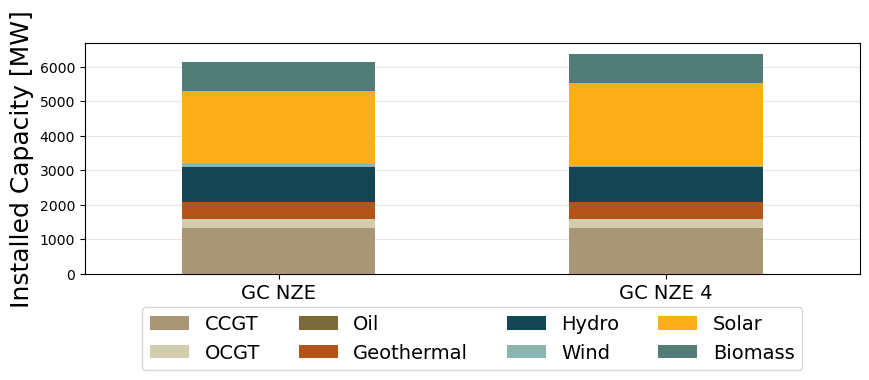

In [23]:

# #base_final_capacity_cap = pd.read_csv(path + 'base_cap_final_capacity.csv', index_col=0)
# #base_final_capacity_cap_4 = pd.read_csv(path + 'base_cap_4_final_capacity.csv', index_col=0)
gradual_final_capacity_cap = pd.read_csv(path + 'gradual_NZE_final_capacity.csv', index_col=0)
gradual_final_capacity_cap_4 = pd.read_csv(path + 'gradual_NZE_4_final_capacity.csv', index_col=0)
#gradual_final_capacity_cap_old = pd.read_csv(path + 'gradual_NZE_old_final_capacity.csv', index_col=0)

desired_order = ['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']

all_data = pd.concat([gradual_final_capacity_cap, gradual_final_capacity_cap_4], axis=0)
all_data.index = ['GC NZE', 'GC NZE 4']
all_data = all_data[desired_order]

ax = all_data.plot(kind='bar', stacked=True, figsize=(10, 3), color=get_colors(all_data.columns), legend=False, zorder=3)   
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=14)
ax.set_ylabel('Installed Capacity [MW]', fontsize=18)   
ax.legend(title='Capacity Type')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=14)
plt.grid(axis='y', zorder=0, color=grey1)
plt.savefig(fig_path + 'final_capacity_4.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
scenarios = ['gradual_NZE', 'gradual_NZE_4']

capcost = pd.read_csv(path + 'capcost.csv')
opcost = pd.read_csv(path + 'opex.csv')

capcost = capcost[scenarios]
total_capcosts = capcost.sum(axis=0) #million
print(total_capcosts)

opcost = opcost[scenarios]
total_opcosts = opcost.sum(axis=0) #million
print(total_opcosts)

gradual_NZE      2800.050468
gradual_NZE_4    2826.928606
dtype: float64
gradual_NZE      721.419843
gradual_NZE_4    691.125522
dtype: float64


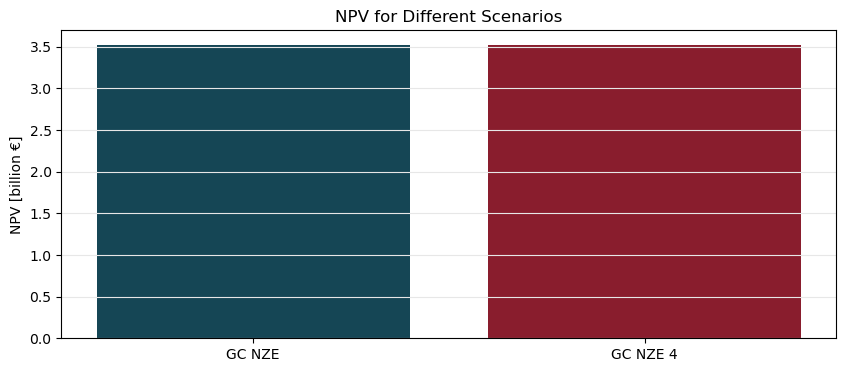

gradual_NZE      3.521470
gradual_NZE_4    3.518054
dtype: float64


In [37]:
scenarios = ['gradual_NZE', 'gradual_NZE_4']
labels = ['GC NZE', 'GC NZE 4']


yearly_costs = pd.read_csv(path + 'total_costs.csv')
#base_adjusted = pd.read_csv(path + 'base_capex_adjusted.csv')
#base_adjusted_4 = pd.read_csv(path + 'base_4_capex_adjusted.csv')

# yearly_costs_base_adjusted = capex_4['base'].sub(base_adjusted['Capex'], axis=0)
# yearly_costs_base_4_adjusted = capex_4['base_4'].sub(base_adjusted_4['Capex'], axis=0)
# yearly_costs_4['gradual_NZE'] = yearly_costs_4['gradual_NZE']
# yearly_costs_4['gradual_NZE_4'] = yearly_costs_4['gradual_NZE_4']
#yearly_costs_all_adjusted = [yearly_costs_all.loc[i,:] - adjustment.loc[i, 'adjustment'] for i in range(len(yearly_costs_all))]

# yearly_costs = yearly_costs_4[scenarios]
# total_costs = yearly_costs.sum(axis=0) 
# total_costs_df = pd.DataFrame(total_costs)
# #total_costs_df.columns = labels



# yearly_costs_base_adjusted = capex['base'].sub(base_adjusted['Capex'], axis=0)
# yearly_costs_adjusted = yearly_costs_all.sub(yearly_costs_base_adjusted, axis=0)
# #yearly_costs_all_adjusted = [yearly_costs_all.loc[i,:] - adjustment.loc[i, 'adjustment'] for i in range(len(yearly_costs_all))]

yearly_costs = yearly_costs[scenarios]
total_costs = yearly_costs.sum(axis=0) /1000
total_costs.columns = labels



costs_dict = {label: total_costs[i] for i, label in enumerate(yearly_costs.columns)}
df = pd.DataFrame([costs_dict])

plt.figure(figsize=(10, 4)) 

num_scenarios = len(df.columns)

df.columns = labels
colors = [teal2, red1]

for i, column in enumerate(df.columns):
    # Calculate the positions for the current column
    positions = range(i, len(df) * len(df.columns), len(df.columns))
    plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

# Set the title and labels
plt.title('NPV for Different Scenarios')
plt.ylabel('NPV [billion €]')

# Set x-ticks to be in the middle of the group of bars for each scenario
tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
plt.xticks(range(num_scenarios), df.columns)

#plt.legend()
plt.grid(axis='y', color=grey1)
#plt.ylim(0,10)
plt.savefig(fig_path + 'npv.png', dpi=300, bbox_inches='tight')
plt.show()

print(total_costs)

In [25]:
# capex_4_all = pd.read_csv(path + 'capex_4.csv')
# scenarios = ['gradual_cap', 'gradual_cap_4']
# capex_4_adjusted = capex_4_all.sub(adjustment.iloc[:, 0], axis=0)
# capex_4 = capex_4_adjusted[scenarios]
# labels = ['GC NZE', 'GC NZE 4']


# years = list(range(2023, 2038))  # From year 2023 to 2037
# capex_4.index = years

# capex_4.columns = labels

# colors = [teal3, red2]

# plt.figure(figsize=(12, 3))  # Adjust the size as needed
# for column in capex_4.columns:
#     capex_4[column].plot(label=column, color=colors[capex_4.columns.get_loc(column)], linewidth=2)
# plt.xlabel('Year', fontsize=14)
# plt.ylabel('CAPEX [million €]', fontsize=14)
# plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
# plt.grid(axis='y')
# plt.ylim(0,400)
# plt.xlim(2023,2037)
# plt.savefig(fig_path + 'capex_4.png', dpi=300, bbox_inches='tight')
# plt.show()

In [26]:
# opex_4_all = pd.read_csv(path + 'opex_4.csv')
# scenarios = ['gradual_cap', 'gradual_cap_4']
# labels = ['GC NZE', 'GC NZE 4']
# opex_4 = opex_4_all[scenarios]


# years = list(range(2023, 2038))  # From year 2023 to 2037
# opex_4.index = years

# opex_4.columns = labels

# colors = [teal3, red2]

# plt.figure(figsize=(12, 3))  # Adjust the size as needed
# for column in opex_4.columns:
#     opex_4[column].plot(label=column, color=colors[opex_4.columns.get_loc(column)], linewidth=2)
# plt.xlabel('Year', fontsize=14)
# plt.ylabel('OPEX [million €]', fontsize=14)
# plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
# plt.grid(axis='y')
# plt.ylim(0,200)
# plt.xlim(2023,2037)
# plt.savefig(fig_path + 'opex_4.png', dpi=300, bbox_inches='tight')
# plt.show()

In [27]:
# import matplotlib.colors as mcolors
# capex_tot = capex_4.sum() / 1000
# capex_tot = pd.DataFrame(capex_tot).T
# opex_tot = opex_4.sum() / 1000
# opex_tot = pd.DataFrame(opex_tot).T

# labels = ['GC NZE', 'GC NZE 4']
# fig, ax = plt.subplots(figsize=(6, 3))

# colors = [teal3, red1]
# index = np.arange(len(capex_4.columns))
# capex_bars = ax.bar(index, capex_tot.iloc[0], label='CAPEX', color=colors, edgecolor=colors)

# fill_colors_with_alpha = [mcolors.to_rgba(color, alpha=0.4) for color in colors] 
# solid_edge_colors = [mcolors.to_rgba(color, alpha=1) for color in colors] 

# opex_bars = ax.bar(index, opex_tot.iloc[0], label='OPEX', bottom=capex_tot.iloc[0], 
#                         color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)

# ax.set_xticks(index)
# ax.set_xticklabels(labels, rotation=0)

# # # Set the y-axis label
# opex_patch = mpatches.Patch(facecolor=grey1, edgecolor='darkgrey', linestyle='--', linewidth=1, label='OPEX')
# capex_patch = mpatches.Patch(color='darkgrey', label='CAPEX')


# # Create the legend with custom patches
# plt.legend(handles=[opex_patch, capex_patch], loc='best', edgecolor=grey1, bbox_to_anchor=(1.05, 0.5))
# plt.ylabel('Cost [billion €]', fontsize=14)
# plt.ylim(0,4)
# plt.grid(axis='y', color=grey1)

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.savefig(fig_path + 'capex_opex_4.png', dpi=300, bbox_inches='tight')
# plt.show()

   gradual_NZE  gradual_NZE_4
0      3.52147       3.518054
   gradual_NZE  gradual_NZE_4
0     1.313166        1.28913


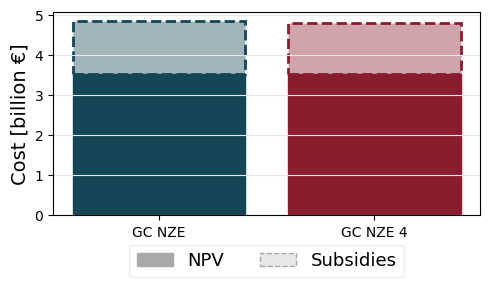

In [28]:
import matplotlib.colors as mcolors
subsidies = pd.read_csv(path + 'subsidies.csv')
subsidies = subsidies / 1000
scenarios = ['gradual_NZE', 'gradual_NZE_4']
labels = ['GC NZE', 'GC NZE 4']
subsidies_4 = subsidies[scenarios]

total_costs_4 = yearly_costs.sum(axis=0) /1000

costs_dict = {label: total_costs_4[i] for i, label in enumerate(yearly_costs.columns)}
df = pd.DataFrame([costs_dict])
print(df)

fig, ax = plt.subplots(figsize=(5, 3))

# The x-axis positions for each bar
index = np.arange(len(df.columns))

colors = [teal2, red1]#, teal3, red2]

total_costs_bars = ax.bar(index, df.iloc[0], label='NPV', color=colors, edgecolor=colors)

fill_colors_with_alpha = [mcolors.to_rgba(color, alpha=0.4) for color in colors]  # Fill colors with transparency
solid_edge_colors = [mcolors.to_rgba(color, alpha=1) for color in colors]  # Edge colors without transparency



# Plotting the subsidies bars on top of the total costs (NPV)
subsidies_bars = ax.bar(index, subsidies_4.iloc[0], label='Subsidies', bottom=df.iloc[0], 
                        color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)

ax.set_xticks(index, fontsize=14)
ax.set_xticklabels(labels, rotation=0)

# # Set the y-axis label
npv_patch = mpatches.Patch(color='darkgrey', label='NPV')
subsidies_patch = mpatches.Patch(facecolor=grey1, edgecolor='darkgrey', linestyle='--', linewidth=1, label='Subsidies')

print(subsidies_4)

# Create the legend with custom patches
plt.legend(handles=[npv_patch, subsidies_patch], loc='upper center', edgecolor=grey1, bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=13)
plt.ylabel('Cost [billion €]', fontsize=14)


# Add a title and a legend

#plt.ylim(0,6)
plt.grid(axis='y', color=grey1)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(fig_path + 'costs_4.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# #base_capacity_factor_cap = pd.read_csv(path + 'base_cap_capacity_factors.csv', index_col=0)
# #base_capacity_factor_cap_4 = pd.read_csv(path + 'base_cap_4_capacity_factors.csv', index_col=0)
# gradual_capacity_factor_cap = pd.read_csv(path + 'gradual_cap_capacity_factors.csv', index_col=0)
# gradual_capacity_factor_cap_4 = pd.read_csv(path + 'gradual_cap_4_capacity_factors.csv', index_col=0)

# desired_order = ['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']
# #base_capacity_factor_cap.columns = ['CCGT', 'OCGT', 'Biomass', 'Geothermal', 'Hydro', 'Oil', 'Wind', 'Solar']
# #base_capacity_factor_cap_4.columns = ['CCGT', 'OCGT', 'Biomass', 'Geothermal', 'Hydro', 'Oil', 'Wind', 'Solar']
# gradual_capacity_factor_cap.columns = ['CCGT', 'OCGT', 'Biomass', 'Geothermal', 'Hydro', 'Oil', 'Wind', 'Solar']
# gradual_capacity_factor_cap_4.columns = ['CCGT', 'OCGT', 'Biomass', 'Geothermal', 'Hydro', 'Oil', 'Wind', 'Solar']


# # scenarios = ['base_cap', 'base_cap_4','gradual_cap', 'gradual_cap_4']
# # labels = ['Base NZE','Base NZE 4', 'GC NZE', 'GC NZE 4']

# # colors = [teal4, red1, teal3, red2]

# scenarios = {
#     #'BASE NZE': base_capacity_factor_cap,
#     #'BASE NZE 4': base_capacity_factor_cap_4,
#     'GC NZE': gradual_capacity_factor_cap,
#     'GC NZE 4': gradual_capacity_factor_cap_4
# }
# colors = get_colors(desired_order)
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=True, sharey=True)
# axes = axes.flatten()  # Flatten if needed

# # Plot each scenario in its own subplot
# for ax, (title, df) in zip(axes, scenarios.items()):
#     for carrier, color in zip(desired_order, colors):
#         if carrier in df.columns:
#             ax.plot(df.index, df[carrier], label=carrier, color=color, marker='o')
#         else:
#             print(f"'{carrier}' not found in '{title}' scenario")
#     ax.set_ylim(0,1)
#     ax.set_xlim(2023,2037)
#     ax.set_title(title)
#     ax.grid(axis='y', color=grey2)

# # Set common labels and title
# fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
# fig.text(0.04, 0.5, 'Capacity Factor', va='center', rotation='vertical', fontsize=14)

# handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
# fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')
# plt.subplots_adjust(hspace=0.3, bottom=0.15)
# plt.savefig(fig_path + 'capacity_factors_4.png', dpi=300, bbox_inches='tight')
# plt.show()

In [30]:
# subsidies = get_subsidies()
# cost_of_subsidies = {}

# for year in years:
#     for (subsidy_year, carrier), subsidy_rate in subsidies.items():
#         if carrier == 'oil':
#             carrier = 'Oil'
#         # Check if we're looking at the correct year for the subsidy
#         if subsidy_year == year:
#             # Initialize a dictionary for this year if not already present
#             if year not in cost_of_subsidies:
#                 cost_of_subsidies[year] = {}

#             cost_of_subsidies[year][carrier] = 0

#             # Check if the carrier is present in the production DataFrame
#             if carrier in production.columns:
#                 # Calculate and store the cost of subsidies for this carrier in this year
#                 cost_of_subsidies[year][carrier] = subsidy_rate * production.loc[year,carrier]

# cost_of_subsidies_df = pd.DataFrame()
# for year, carriers in cost_of_subsidies.items():
#     for carrier, cost in carriers.items():
#         cost_of_subsidies_df.loc[year, carrier] = cost
# cost_of_subsidies_df = rename_columns(cost_of_subsidies_df)
# cost_of_subsidies_df.plot(kind='bar', figsize=(12, 6), color=get_colors(cost_of_subsidies_df.columns))
# plt.title(case + ' - Costs due to subsidies')
# plt.ylabel('Cost (Million €)')
# plt.xlabel('Year')
# plt.ylim(0,300)
# plt.grid(axis='y')
# #plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

In [31]:
# yearly_subsidies = cost_of_subsidies_df.sum(axis=1)
# pv_subsidies = [calculate_present_value(yearly_subsidies.loc[years[i]], years[i], first_year, 0.04) for i in range(len(years))]
# npv_subsidies = sum(pv_subsidies)

# plt.figure(figsize=(10, 3))
# plt.plot(years, pv_subsidies, color=teal3)
# plt.xticks(years, [int(year) for year in years])
# plt.title('Present Value of Subsidies')
# plt.xlabel('Year')
# plt.ylabel('Present Value (Million €)')
# plt.xlim(first_year,final_year)
# #plt.ylim(0,300)
# plt.grid(axis='y')
# plt.show()
